# Captcha_CNN

***Mo Wu  (mw3774)         Mingdi Han  (mh4928)***

with colab link:https://colab.research.google.com/drive/1h4q1t9rrV3sn93ly3t5J9L2qtr2gYUeC

In [0]:
pip install captcha

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8807942581153064388
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4928169776047858575
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8137860343466012953
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 986641800394708902
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
import random 
import numpy as np 
from PIL import Image 
import matplotlib.pyplot as plt 
from captcha.image import ImageCaptcha
import os 
import tensorflow as tf

In [0]:
Number = ['0','1','2','3','4','5','6','7','8','9']
 
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
 
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

CAPTCHA_LIST = Number + alphabet + ALPHABET
 
CAPTCHA_LEN = 4
 
CAPTCHA_HEIGHT = 60
 
CAPTCHA_WIDTH = 160




In [0]:
def random_captcha_text(char_set= CAPTCHA_LIST, captcha_size=CAPTCHA_LEN):
    captcha_text = []
    for i in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    return captcha_text

def gen_captcha_text_and_image(width=CAPTCHA_WIDTH, height=CAPTCHA_HEIGHT,save=None):
    image = ImageCaptcha(width=width, height=height)
    captcha_text = random_captcha_text()    
    captcha_text = ''.join(captcha_text)
    captcha = image.generate(captcha_text)
    if save: image.write(captcha_text, captcha_text + '.jpg')
    captcha_image = Image.open(captcha)
    captcha_image = np.array(captcha_image)
    
    return captcha_image, captcha_text

Text(0.5, 1.0, 'p3Jf')

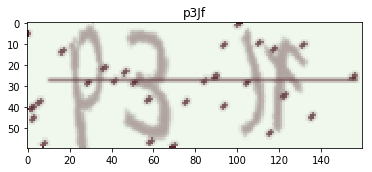

In [0]:
img,text = gen_captcha_text_and_image(CAPTCHA_WIDTH, CAPTCHA_HEIGHT, save=False)
plt.imshow(img)
plt.title(text)


In [0]:

def text2vec(text, captcha_len=CAPTCHA_LEN, captcha_list=CAPTCHA_LIST):
    text_len = len(text)
    if text_len > captcha_len:
        raise ValueError('Error in Length')
    vector = np.zeros(captcha_len * len(captcha_list))
    for i in range(text_len): 
        vector[captcha_list.index(text[i])+i*len(captcha_list)] = 1
    return vector


def vec2text(vec, captcha_list=CAPTCHA_LIST, size=CAPTCHA_LEN): 
    vec_idx = vec
    text_list = [captcha_list[v] for v in vec_idx]
    return ''.join(text_list)



def get_next_batch(batch_size, width=CAPTCHA_WIDTH, height=CAPTCHA_HEIGHT):
    batch_x = np.zeros([batch_size, width * height])
    batch_y = np.zeros([batch_size, CAPTCHA_LEN * len(CAPTCHA_LIST)])
    for i in range(batch_size):
        image,text = gen_captcha_text_and_image()
        if len(image.shape) > 2:
            image = np.mean(image, -1)
        batch_x[i, :] = image.flatten()/255
        batch_y[i, :] = text2vec(text)
    return batch_x, batch_y




In [0]:
X, y = get_next_batch(batch_size = 1)

In [0]:

def cnn_graph(x, keep_prob, size, captcha_list=CAPTCHA_LIST, captcha_len=CAPTCHA_LEN, w_alpha=0.01, b_alpha=0.1):
    # reshape image
    image_height, image_width = size
    x_image = tf.reshape(x, shape=[-1, image_height, image_width, 1])
    
    # conv1
    w_conv1 = tf.Variable(w_alpha * tf.random_normal([3, 3, 1, 32]), name='w_conv1')  # filter:3*3,INPUT CHANNEL 1(GRAY)，OUTPUT（FEATURES）：32
    b_conv1 = tf.Variable(b_alpha * tf.random_normal([32]),name='b_conv1')
    #  activition function :ReLU
    h_conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x_image, w_conv1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1))
    # pooling 
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # dropout
    h_drop1 = tf.nn.dropout(h_pool1, keep_prob)
 
    # convc2
    #w_conv2 = weight_variable([3, 3, 32, 64])
    #b_conv2 = bias_variable([64])
    w_conv2 = tf.Variable(w_alpha * tf.random_normal([3, 3, 32, 64]),name='w_conv2')
    b_conv2 = tf.Variable(b_alpha * tf.random_normal([64]),name='b_conv2')
    h_conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(h_drop1, w_conv2, strides=[1, 1, 1, 1], padding='SAME'), b_conv2))
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_drop2 = tf.nn.dropout(h_pool2, keep_prob)
 
    # conv3
    #w_conv3 = weight_variable([3, 3, 64, 64])
    #b_conv3 = bias_variable([64])
    w_conv3 = tf.Variable(w_alpha * tf.random_normal([3, 3, 64, 64]),name='w_conv3')
    b_conv3 = tf.Variable(b_alpha * tf.random_normal([64]),name='b_conv3')
    h_conv3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(h_drop2, w_conv3, strides=[1, 1, 1, 1], padding='SAME'), b_conv3))
    h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_drop3 = tf.nn.dropout(h_pool3, keep_prob)
 
    # fully connection
    image_height = int(h_drop3.shape[1])
    image_width = int(h_drop3.shape[2])
    w_fc = tf.Variable(w_alpha * tf.random_normal([image_height*image_width*64, 1024]), name = 'w_fc') #怎么定的
    b_fc = tf.Variable(w_alpha * tf.random_normal([1024]),name = 'b_fc') 
    h_drop3_re = tf.reshape(h_drop3, [-1, image_height*image_width*64])
    h_fc = tf.nn.relu(tf.add(tf.matmul(h_drop3_re, w_fc), b_fc))
    h_drop_fc = tf.nn.dropout(h_fc, keep_prob)
    
    # output
    #w_out = weight_variable([1024, len(captcha_list)*captcha_len])
    #b_out = bias_variable([len(captcha_list)*captcha_len])
    w_out = tf.Variable(w_alpha * tf.random_normal([1024, len(captcha_list)*captcha_len]),name = 'w_out') #怎么定的
    b_out = tf.Variable(w_alpha * tf.random_normal([len(captcha_list)*captcha_len]),name = 'b_out') 
    y_conv = tf.add(tf.matmul(h_drop_fc, w_out), b_out)
    
    variables_dict = {'w_conv1': w_conv1, 'b_conv1': b_conv1,'w_conv2': w_conv2, 'b_conv2': b_conv2, 
                      'w_conv3': w_conv3, 'b_conv3': b_conv3 ,'w_fc': w_fc, 'b_fc': b_fc,'w_out': w_out, 'b_out': b_out}
 
    return y_conv, variables_dict
 
 
 
# MINIMIZE loss
 
def optimize_graph(y, y_conv):
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_conv, labels=y))
    # 
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
 
    return optimizer
 
 
 
# COMPUTE BIAS
 
def accuracy_graph(y, y_conv, width=len(CAPTCHA_LIST), height=CAPTCHA_LEN):
    
    predict = tf.reshape(y_conv, [-1, height, width])
    max_predict_idx = tf.argmax(predict, 2)
 
    # labels
    label = tf.reshape(y, [-1, height, width])
    max_label_idx = tf.argmax(label, 2)
    correct_p = tf.equal(max_predict_idx, max_label_idx)
    accuracy = tf.reduce_mean(tf.cast(correct_p, tf.float32))
 
    return accuracy

def train(height=CAPTCHA_HEIGHT, width=CAPTCHA_WIDTH, y_size=len(CAPTCHA_LIST)*CAPTCHA_LEN):
    acc_rate = 0.93
    #pre-occupied
    x = tf.placeholder(tf.float32, [None, height * width])
    y = tf.placeholder(tf.float32, [None, y_size])
    keep_prob = tf.placeholder(tf.float32) # prevent from overfit ,only use in trining
    
    # CNN model
    y_conv ,var_dict= cnn_graph(x, keep_prob, (height, width))
    # 
    optimizer = optimize_graph(y, y_conv)
    # 
    accuracy = accuracy_graph(y, y_conv)
    
    #begin 
    saver = tf.train.Saver(var_dict)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    step = 0
    Acc=[]
    xplt=[]
 
    while 1:
        batch_x, batch_y = get_next_batch(100)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        # 
        if step % 100 == 0:
            batch_x_test, batch_y_test = get_next_batch(100)
            acc = sess.run(accuracy, feed_dict={x: batch_x_test, y: batch_y_test, keep_prob: 1.0})
            Acc.append(acc)
            xplt.append(step)
            
            
            print(' step:', step, ' accuracy:', acc)
            
            # save model when satisfied 
            if acc >= acc_rate:
                model_path = os.getcwd() + os.sep + str(acc_rate) + "captcha.model"
                saver.save(sess, model_path, global_step=step)
                acc_rate += 0.01
                if acc_rate > 0.94: 
                    break
 
        step += 1
    plt.plot(Acc)
    plt.title('Accuracy')
    plt.show()
 
    sess.close()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
 step: 0  accuracy: 0.015
 step: 100  accuracy: 0.0125
 step: 200  accuracy: 0.0175
 step: 300  accuracy: 0.0125
 step: 400  accuracy: 0.0275
 step: 500  accuracy: 0.01
 step: 600  accuracy: 0.0225
 step: 700  accuracy: 0.0075
 step: 800  accuracy: 0.04
 step: 900  accuracy: 0.0225
 step: 1000  accuracy: 0.0225
 step: 1100  accuracy: 0.0175
 step: 1200  accuracy: 0.0175
 step: 1300  accuracy: 0.0175
 step: 1400  accuracy: 0.0075
 step: 1500  accuracy: 0.0125
 step: 1600  accuracy: 0.03
 step: 1700  accuracy: 0.02
 step: 1800  accuracy: 0.0175
 step: 1900  accuracy: 0.015
 step: 2000  accuracy: 0.015
 step: 2100  accuracy: 0.015
 step: 2200  accuracy: 0.0175
 step: 2300  accuracy: 0.0175
 step: 2400  accuracy: 0.0125
 step: 2500  accuracy: 0.015
 step: 2600  accuracy: 0.0075
 step: 2700  accuracy: 0.015

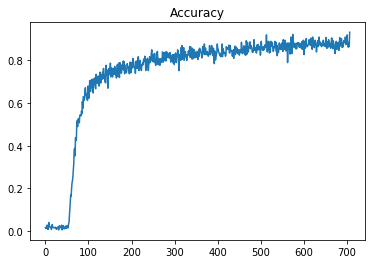

In [0]:
train()

In [0]:

def captcha_decode(image_list, height=CAPTCHA_HEIGHT, width=CAPTCHA_WIDTH):
  x = tf.placeholder(tf.float32, [None, height * width])
  keep_prob = tf.placeholder(tf.float32)
  y_conv, var_dict = cnn_graph(x, keep_prob, (height, width))
  saver = tf.train.Saver(var_dict)
  
  #saver = tf.train.import_meta_graph(os.getcwd()+'/0.93captcha.model-70600.meta')
  with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predict = tf.argmax(tf.reshape(y_conv, [-1, CAPTCHA_LEN, len(CAPTCHA_LIST)]), 2)
    vector_list = sess.run(predict, feed_dict={x: image_list, keep_prob: 1})
    vector_list = vector_list.tolist()
    text_list = [vec2text(vector) for vector in vector_list]
 
  return text_list

In [0]:
from tensorflow.python import pywrap_tensorflow

reader = pywrap_tensorflow.NewCheckpointReader('/content/0.93captcha.model-70600')
var_to_shape_map = reader.get_variable_to_shape_map()
for key in var_to_shape_map:
  print("tensor_name: ", key)


tensor_name:  w_fc
tensor_name:  w_conv2
tensor_name:  b_conv2
tensor_name:  b_fc
tensor_name:  w_out
tensor_name:  w_conv3
tensor_name:  b_conv1
tensor_name:  b_conv3
tensor_name:  b_out
tensor_name:  w_conv1


INFO:tensorflow:Restoring parameters from /content/0.93captcha.model-70600
Label: 57sG  Predict: ['57sG']


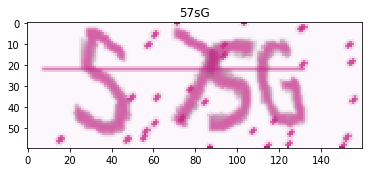

In [0]:
image, text = gen_captcha_text_and_image()
plt.imshow(image)
plt.title(text)
if len(image.shape) > 2:
  image = np.mean(image, -1)
  image = image.flatten()/255
pre_text = captcha_decode([image])
print('Label:', text, ' Predict:', pre_text)
